# Setup

In [32]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from scipy import stats

dl = DataLib("SignalData")

plt.style.use("seaborn")

In [33]:
# Pull all the necessary dataframes to avoid duplicate code. 
bri = dl.pull("BondRetIdx/LocalFX")
lr = dl.pull("LongRates")
sr = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
core_cpi = dl.pull("CoreCPI/SA")
rfRates = dl.pull("RiskfreeRates")

In [34]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4
COUNTRIES=[
    'USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU'
]

# Get z-scores

Pull these from the data library (I've saved them here). 

In [4]:
GDP_zscore = dl.pull('GDP_zscore')
premium_zscore = dl.pull('premium_zscore')
height_zscore = dl.pull("height_zscore")

# Returns: GDP indicator

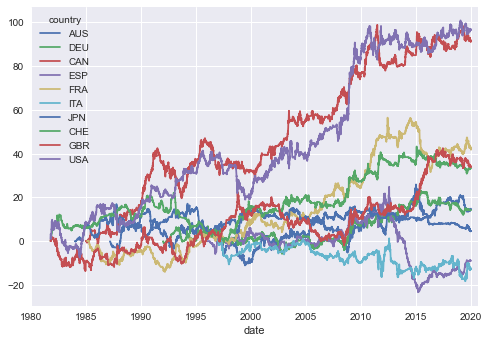

<function matplotlib.pyplot.show(close=None, block=None)>

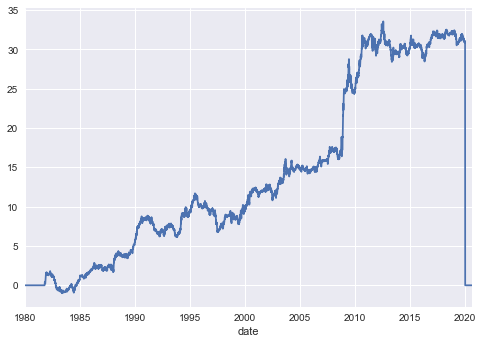

In [5]:
signal = GDP_zscore.clip(upper=1.5, lower=-1.5) / 1.5
signal = signal[signal.index < '2020-01-01']
signal_gdp = signal.resample('B').ffill()

# Calculate cumulative returns. 
bri_chg = bri.pct_change()
returns_gdp = (bri_chg.shift(-1) * signal_gdp)       
cumul_returns_gdp = ((returns_gdp + 1).cumprod() - 1) * 100

# Plot the returns for each country. 
cumul_returns_gdp.plot()
plt.show()

# Plot the total returns.
(cumul_returns_gdp * 0.1).sum(axis=1).plot()
plt.show

# Returns: Bond Premium indicator

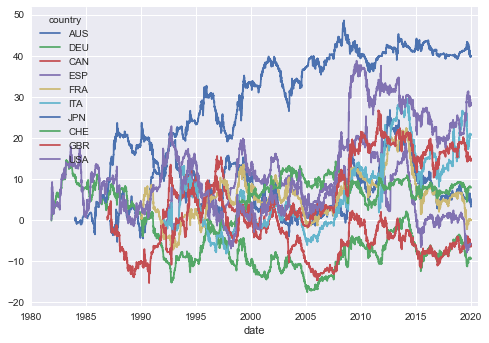

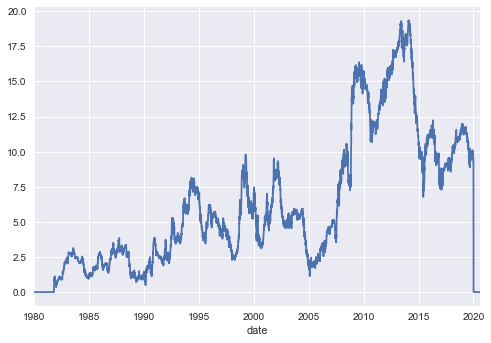

In [38]:
signal = premium_zscore.clip(upper=2, lower=-2) / 2
signal = signal[signal.index < '2020-01-01']
signal_premium = signal.resample('B').ffill()

# Calculate cumulative returns. 
bri_chg = bri.pct_change()
returns_premium = (bri_chg.shift(-1) * signal_premium)       
cumul_returns_premium = ((returns_premium + 1).cumprod() - 1) * 100

# Plot the returns. 
cumul_returns_premium.plot()
plt.show()

# Plot the total returns (assume equal amount of capital in each market).
(cumul_returns_premium * 0.1).sum(axis=1).plot()
plt.show()

# Returns: Curve height indicator

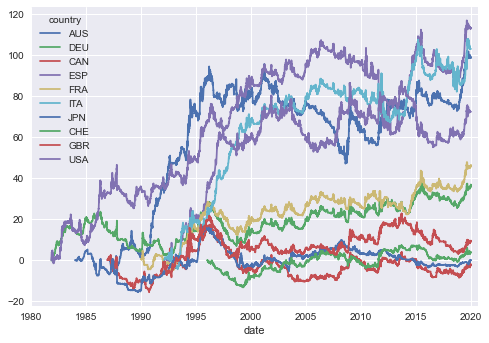

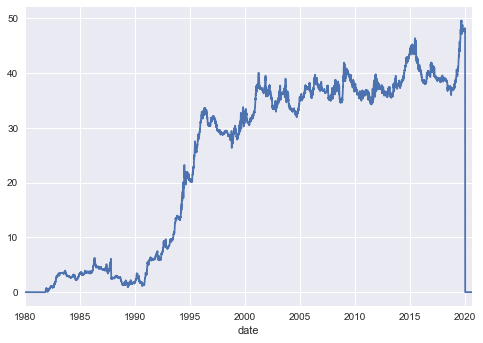

In [7]:
signal = height_zscore.clip(upper=2, lower=-2) / 2
signal = signal[signal.index < '2020-01-01']
signal_height = signal.resample('B').ffill()

# Calculate cumulative returns. 
bri_chg = bri.pct_change()
returns_height = (bri_chg.shift(-1) * signal_height)       
cumul_returns_height = ((returns_height + 1).cumprod() - 1) * 100

# Plot the returns for each country. 
cumul_returns_height.plot()
plt.show()

# Plot the total returns (assume equal amount of capital in each market).
(cumul_returns_height * 0.1).sum(axis=1).plot()
plt.show()

# Correlation between return streams

In [8]:
print('average correlations across indicator return streams')
print()

print('premium and gdp')
print("{:.2f}".format(np.mean(returns_gdp.corrwith(returns_premium))))
print()

print('gdp and curve height')
print("{:.2f}".format(np.mean(returns_gdp.corrwith(returns_height))))
print()

print('premium and curve height')
print("{:.2f}".format(np.mean(returns_premium.corrwith(returns_height))))
print()

average correlations across indicator return streams

premium and gdp
-0.06

gdp and curve height
-0.00

premium and curve height
0.15



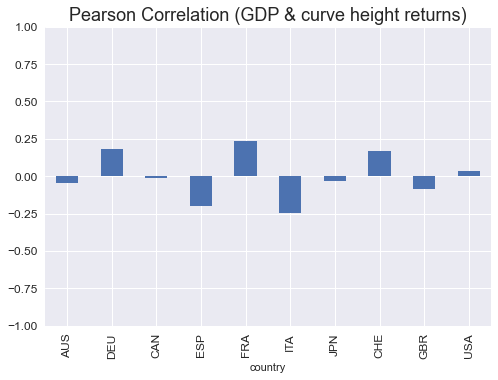

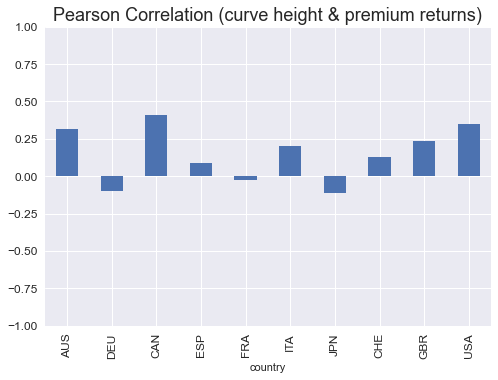

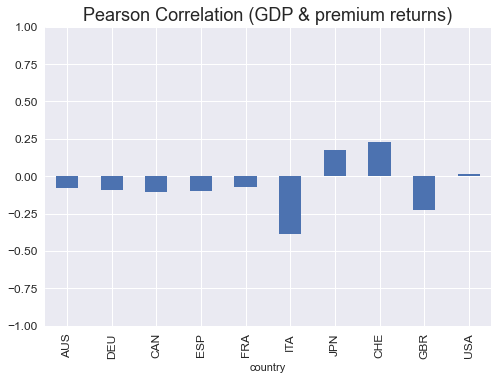

In [9]:
ax = returns_height.corrwith(returns_gdp).plot.bar(title='Pearson Correlation (GDP & curve height returns)', fontsize=12)
ax.title.set_size(18)
plt.ylim(-1, 1)
plt.show()

ax = returns_height.corrwith(returns_premium).plot.bar(title='Pearson Correlation (curve height & premium returns)', fontsize=12)
plt.ylim(-1, 1)
ax.title.set_size(18)
plt.show()

ax = returns_gdp.corrwith(returns_premium).plot.bar(title='Pearson Correlation (GDP & premium returns)', fontsize=12)
ax.title.set_size(18)
plt.ylim(-1, 1)
plt.show()

# Returns in risk-adjusted space

In [26]:
def get_excess_returns():

    # Convert from monthly to daily rf rates.
    series = rfRates / 100
    series = series.resample('B').ffill()
    series = (series + 1) ** (1 / WORKDAYS_IN_YEAR) - 1
    series = series.loc[bri.index]
    
    # Convert this series to a dataframe.
    rf_rates = bri.copy()
    for country in rf_rates.columns.values: 
        rf_rates[country] = series
        
    # Subtract the rates from the change in bond returns. 
    return bri.pct_change() - rf_rates

In [27]:
'''
    Return the Sharpe ratio given a signal.
'''
def get_sharpe(signal): 
    return np.mean([get_country_sharpe(signal, country) for country in COUNTRIES])

'''
    Return the Sharpe ratio given a signal for a given country.
'''
def get_country_sharpe(signal, country): 
    
    # Get the returns of this strategy
    excess_returns = get_excess_returns()
    returns = signal * excess_returns.shift(-1)
    
    gmean = stats.gmean((1 + returns[country]).dropna())
    annualized_return = (gmean ** 261) - 1
    risk = returns[country].std() * np.sqrt(261)
    
    return annualized_return/risk

Returns for the two indicators in absolute space:

<AxesSubplot:xlabel='date'>

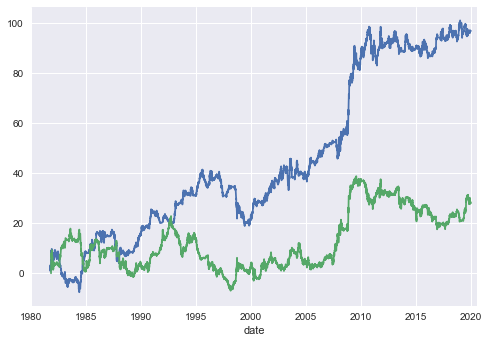

In [28]:
cumul_returns_gdp['USA'].plot()
cumul_returns_premium['USA'].plot()

Let's normalize by the volatility of each return stream, and then compare the two. 

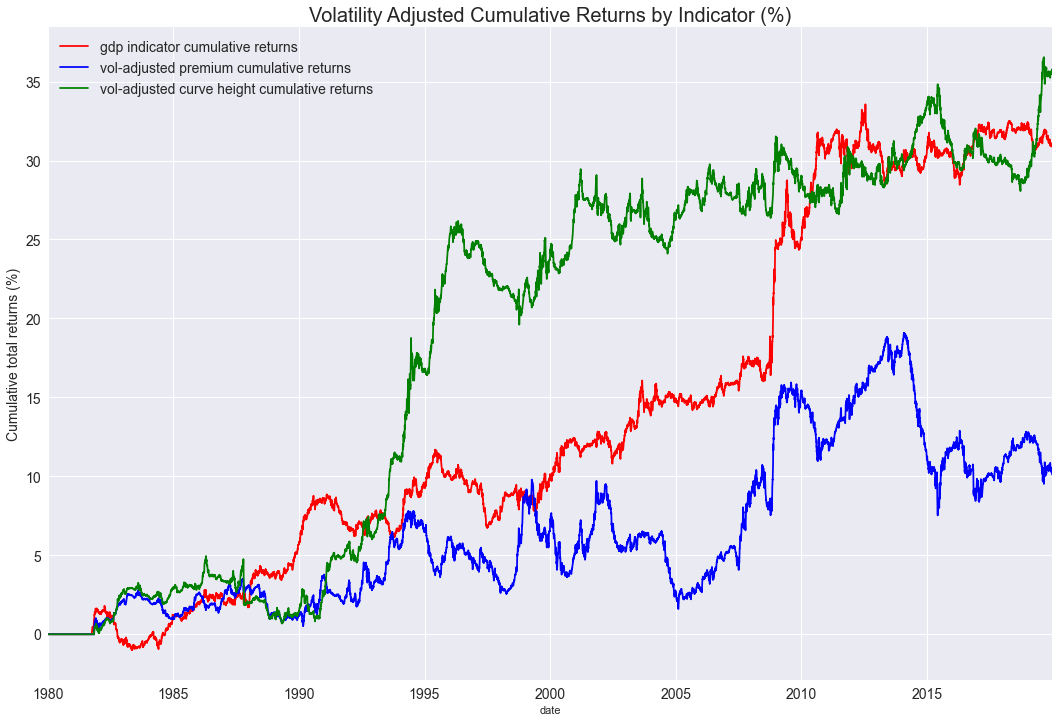

In [13]:
# Get the volatility for both portfolios. 
vol_gdp = returns_gdp.std(axis=0) * 100
vol_premium = returns_premium.std(axis=0) * 100
vol_height = returns_height.std(axis=0) * 100

fig, ax = plt.subplots(figsize=(18,12))

# Plot the returns for our GDP indicator.
cumul_returns = (cumul_returns_gdp * 0.1).sum(axis=1)
cumul_returns = cumul_returns[cumul_returns.index < '2020-01-01']
cumul_returns.plot(color='red', label='gdp indicator cumulative returns')

# Plot the volatility-adjusted returns for premium indicator.
returns_premium_voladj = returns_premium.divide(vol_premium, axis=1)
returns_premium_voladj = returns_premium_voladj.multiply(vol_gdp, axis=1)
cumul_returns = ((0.1*returns_premium_voladj + 1).cumprod() - 1) * 100
cumul_returns_premium_voladj = cumul_returns[cumul_returns.index < '2020-01-01']
cumul_returns_premium_voladj.sum(axis=1).plot(color='blue', label='vol-adjusted premium cumulative returns')
plt.legend(loc=0)

# Plot the volatility-adjusted returns for curve height indicator.
returns_height_voladj = returns_height.divide(vol_height, axis=1)
returns_height_voladj = returns_height_voladj.multiply(vol_gdp, axis=1)
cumul_returns = ((0.1*returns_height_voladj + 1).cumprod() - 1) * 100
cumul_returns_height_voladj = cumul_returns[cumul_returns.index < '2020-01-01']
ax = cumul_returns_height_voladj.sum(axis=1).plot(color='green', label='vol-adjusted curve height cumulative returns', fontsize=14)
ax.set_ylabel("Cumulative total returns (%)", fontsize=14)
plt.legend(loc=2, prop={'size': 14})
plt.title('Volatility Adjusted Cumulative Returns by Indicator (%)')
ax.title.set_size(20)
plt.show()

Look at Sharpe ratios by country for our GDP indicator. 

In [14]:
print('gdp sharpe:', get_sharpe(signal_gdp))

gdp sharpe: 0.15631430496951956


In [15]:
print('premium sharpe:', get_sharpe(signal_premium))

premium sharpe: 0.05753071598645025


In [16]:
print('curve height sharpe:', get_sharpe(signal_height))

curve height sharpe: 0.2336867986156886


# Combining indicators

In [17]:
def plot_returns(signal, title1, title2): 
    
    # Ensure the signal is sampled every business day. 
    signal = signal.resample('B').ffill()

    # Calculate cumulative returns. 
    bri_chg = bri.pct_change()
    returns = (bri_chg.shift(-1) * signal)  
    returns = returns.loc[signal.index]
    cumul_returns = ((returns + 1).cumprod() - 1) * 100

    # Plot the returns for each country. 
    ax = cumul_returns.plot(title=title1, figsize=(14,12), fontsize=14, cmap='rainbow')
    ax.title.set_size(20)
    ax.set_ylabel("Cumulative returns (%)", fontsize=14)
    plt.show()

    # Plot the total returns (assume equal amount of capital in each market).
    ax = (cumul_returns * 0.1).sum(axis=1).plot(title=title2, figsize=(14,12), fontsize=14)
    ax.title.set_size(20)
    ax.set_ylabel("Cumulative total returns (%)", fontsize=14)
    plt.show()

In [18]:
# Returns a signal based on a decision scheme to combine the given indicators.
def combine_scheme1(indicators): 
    signal = pd.DataFrame(indicators[0], index=indicators[0].index)

    # Obtain which indicators are being used at which point.
    ind_names = ['gdp', 'premium', 'height']
    ind_indices = {'gdp':0, 'premium':1, 'height':2}
    ind_count = Counter()
    
    for country in COUNTRIES:
        for date in signal.index: 
            
            # Sort the values by magnitude. 
            values = [ind[country].loc[date] for ind in indicators]
            sorted_names = sorted(ind_names, key=lambda x: abs(indicators[ind_indices[x]][country].loc[date]), reverse=True)
            values.sort(key=lambda x: abs(x), reverse=True)
            
            # Determine what our signal should be. 
            if values[0] * values[1] > 0: 
                signal[country].loc[date] = values[0]
            else: 
                signal[country].loc[date] = (1/3) * values[0] + (1/3) * values[1] + (1/3) * values[2]
                ind_count[sorted_names[2]] += 1
                
            # Increment our counts of each indicator's usage.   
            ind_count[sorted_names[0]] += 1
            ind_count[sorted_names[1]] += 1
            
    print('count of each indicator:', ind_count)
    return signal

In [19]:
scheme1 = combine_scheme1([signal_gdp, signal_premium, signal_height])

count of each indicator: Counter({'height': 93340, 'premium': 91372, 'gdp': 87109})


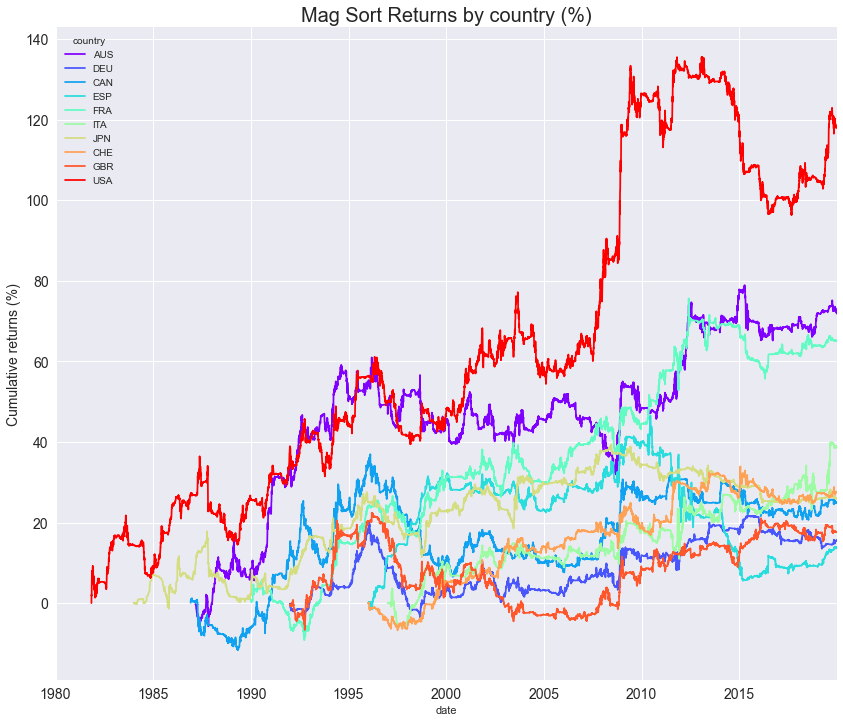

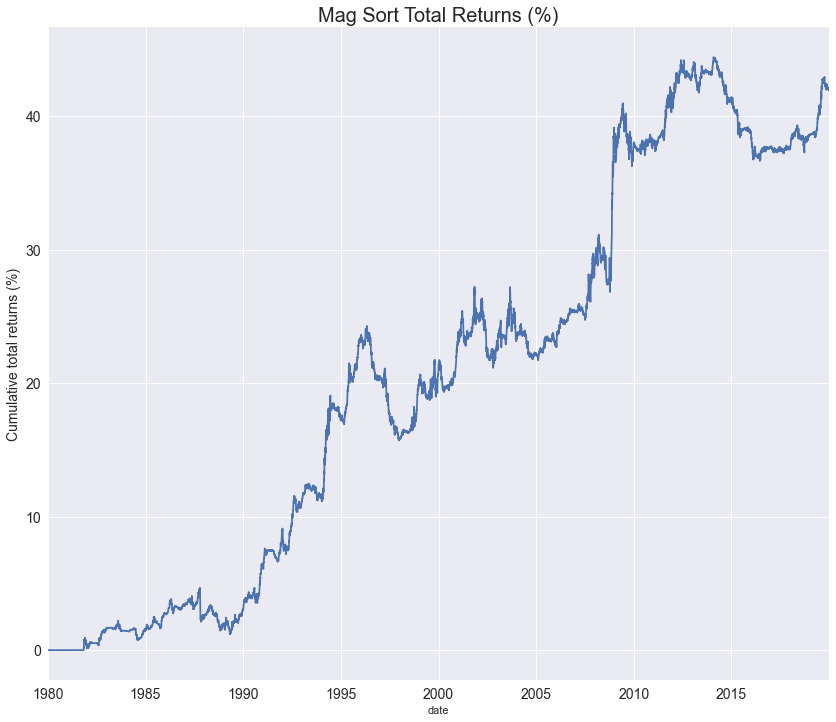

In [20]:
plot_returns(scheme1, "Mag Sort Returns by country (%)", "Mag Sort Total Returns (%)")

In [21]:
print('scheme1 sharpe:', get_sharpe(scheme1))

scheme1 sharpe: 0.25246952677890483


Let's try an equal weighting of the three indicators.

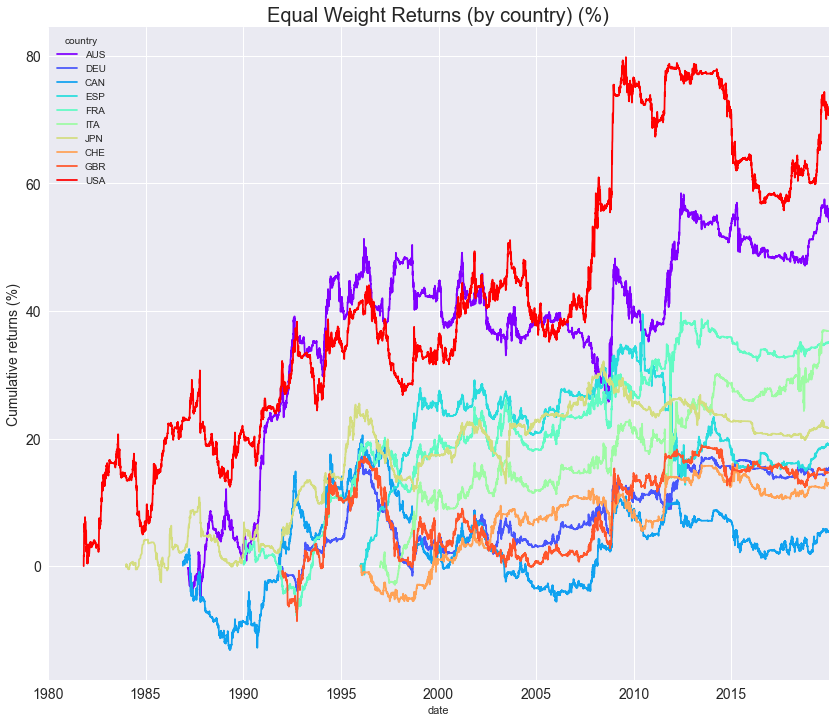

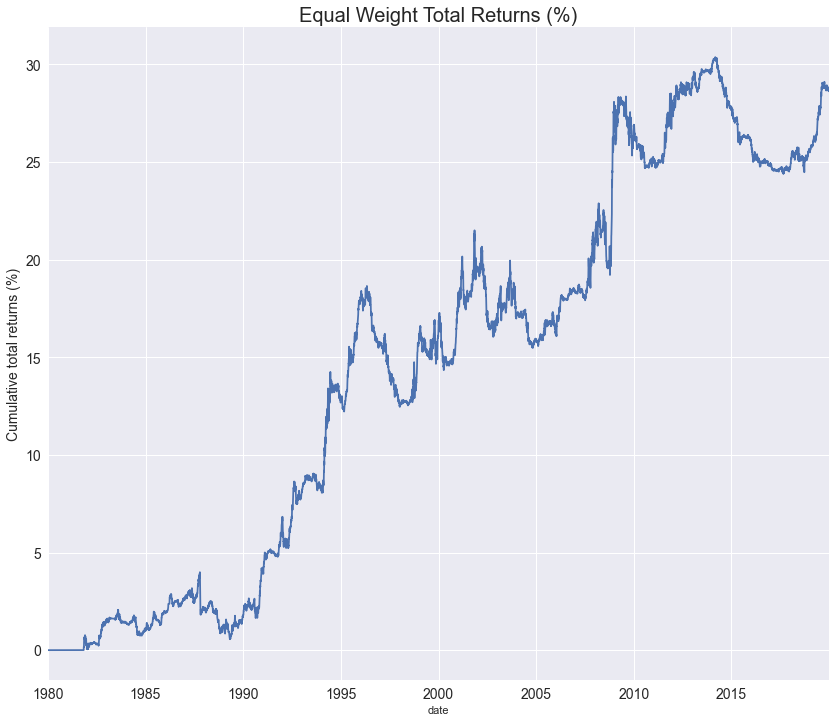

equal weighting sharpe: 0.2310263310475146


In [22]:
signal = (1/3) * signal_gdp + (1/3) * signal_premium + (1/3) * signal_height
plot_returns(signal, "Equal Weight Returns (by country) (%)", "Equal Weight Total Returns (%)")

print('equal weighting sharpe:', get_sharpe(signal))

Let's try just GDP and curve height in equal weightings. 

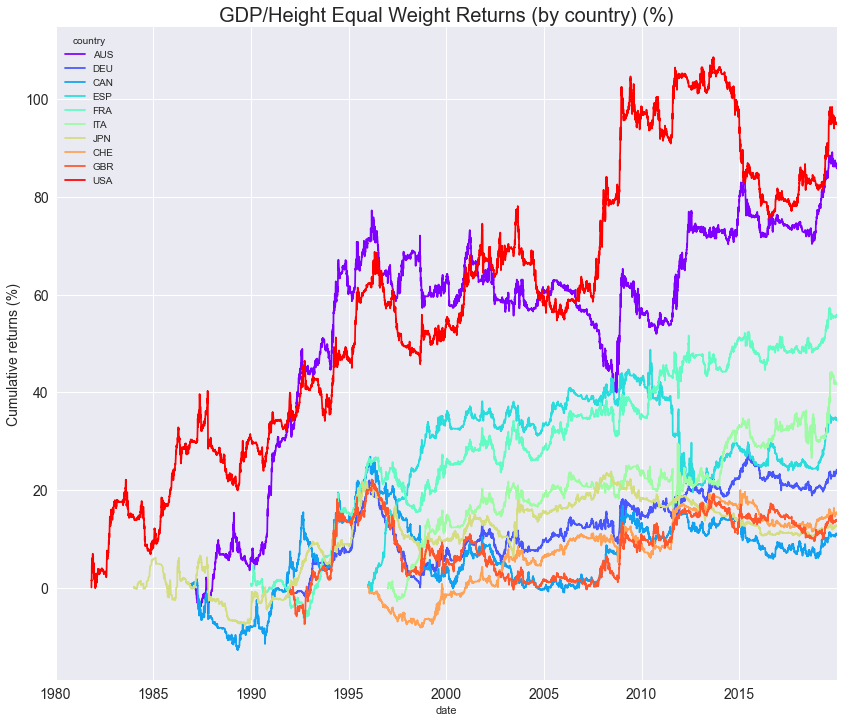

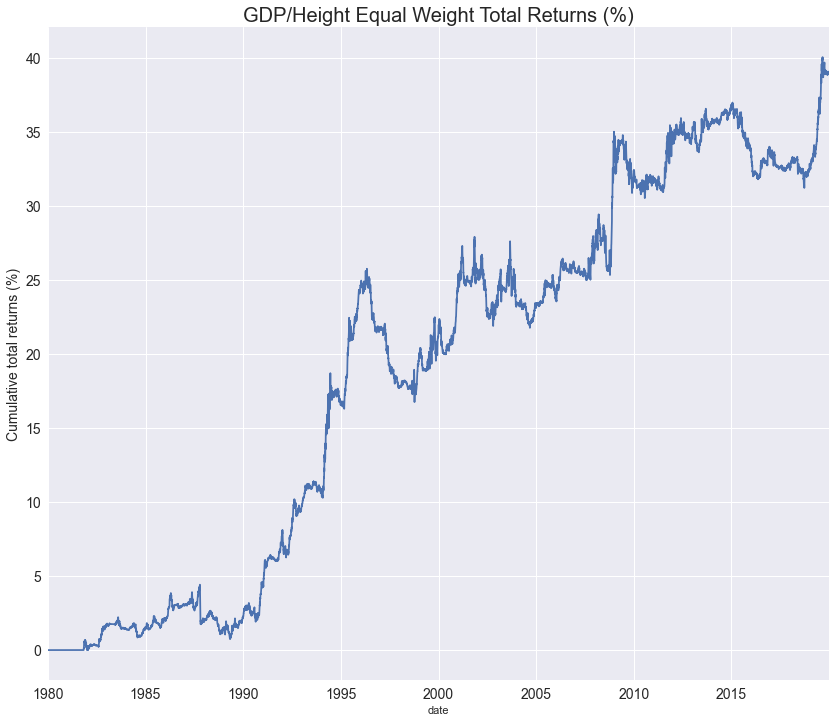

gdp/height equal weight sharpe: 0.2554953456560568


In [23]:
signal = (1/2) * signal_gdp + (1/2) * signal_height
plot_returns(signal, "GDP/Height Equal Weight Returns (by country) (%)", "GDP/Height Equal Weight Total Returns (%)")

print('gdp/height equal weight sharpe:', get_sharpe(signal))

# Non-equal weighting scheme
What if instead of putting equal amounts of money in each market, we introduced a set of weights, telling us what proportion of the total to put into each market. These weights could be based on the strength of a signal for some past window. For instance, if the signal for Australia was consistently stronger for the past 100 days than the signal for America, we might want to put more money in our Australian market. 

`todo`
- figure out this weighting scheme
- calculate some rolling window average for each market
- use this rolling average to determine weights

In [24]:
# Return weights every day for a signal. 
def get_weights(signal): 
    
    # Get the rolling average of the magnitude of the signal.
    window = abs(signal).rolling(100).mean()
    
    # Normalize this rolling window to get the weights. 
    weights = window.divide(window.sum(axis=1), axis=0)
    
    return weights

equal weight sharpe (with weighted allocations): 0.2310263310475146


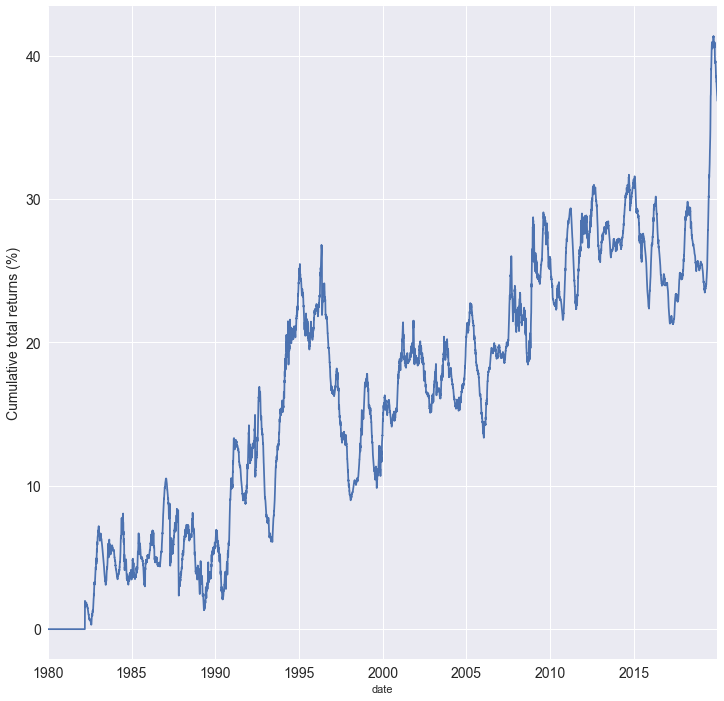

In [25]:
signal = (1/3) * signal_gdp + (1/3) * signal_premium + (1/3) * signal_height
weights = get_weights(signal)
print('equal weight sharpe (with weighted allocations):', get_sharpe(signal))

# Calculate cumulative returns. 
bri_chg = bri.pct_change()
returns = (bri_chg.shift(-1) * signal)  
returns = returns.loc[signal.index]
cumul_returns = (((returns + 1).cumprod() - 1) * 100) * weights

# Plot the total returns (assume equal amount of capital in each market).
ax = cumul_returns.sum(axis=1).plot(figsize=(12,12), fontsize=14)
ax.title.set_size(20)
ax.set_ylabel("Cumulative total returns (%)", fontsize=14)
plt.show()